# Balance de blancos con White-Patch

En este cuaderno implementamos el algoritmo **White-Patch** para corregir el balance de blancos de las imágenes provistas. El flujo es:

1. Detectar el canal con mayor respuesta (parche blanco) para cada componente RGB.
2. Calcular factores de escala para normalizar dichos máximos a 255.
3. Aplicar la ganancia a todos los píxeles y comparar el resultado con las imágenes originales.

## Fallas frecuentes del White-Patch
Aunque el algoritmo es sencillo, asume la presencia de un parche blanco representativo y una respuesta lineal. Puede fallar en:

- **Escena sin blancos reales**: la ganancia se ajusta a un color incorrecto y deja dominante.
- **Destellos especulares o saturaciones puntuales**: el máximo lo producen reflejos y genera ganancias exageradas; usar percentiles <100 ayuda.
- **Iluminaciones mixtas**: un factor global por canal no corrige varias luces simultáneas, dejando zonas con distinto tinte.
- **Clipping o compresión**: si el sensor recortó los valores altos, el máximo observado es bajo y el balance queda insuficiente o posteriza.
- **Escenas oscuras con ruido**: el máximo proviene de ruido electrónico y hace que toda la imagen quede sobreexpuesta.
- **Espacios no lineales (sRGB/gamma)**: la proporcionalidad entre canales se rompe y persisten dominantes.

Cuando se dan estos casos conviene recurrir a variantes como Gray-World, Shades-of-Gray o métodos aprendidos.

## Cargar dependencias
Importamos las bibliotecas requeridas para manipular rutas, procesar imágenes y visualizar resultados.

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.titlesize"] = 12

## Localizar el conjunto de datos
Buscamos las imágenes dentro de `data/withe-patch` (según el enunciado). Si esa carpeta no existe intentamos variantes razonables y, finalmente, `images/white_patch` incluida en este repositorio.

In [2]:
VALID_EXTENSIONS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
DATA_DIR_CANDIDATES = [
    Path("data/withe-patch"),
    Path("data/white-patch"),
    Path("data/white_patch"),
    Path("images/white_patch"),
]

for candidate in DATA_DIR_CANDIDATES:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    raise FileNotFoundError(
        "No se encontró ninguna carpeta con imágenes."
    )

image_paths = sorted(
    [p for p in DATA_DIR.iterdir() if p.suffix.lower() in VALID_EXTENSIONS]
)

if not image_paths:
    raise RuntimeError(
        f"No se detectaron imágenes con extensiones válidas en {DATA_DIR}"
    )

print(f"Usando {DATA_DIR} con {len(image_paths)} imágenes")
image_paths

Usando images/white_patch con 8 imágenes


[PosixPath('images/white_patch/test_blue.png'),
 PosixPath('images/white_patch/test_green.png'),
 PosixPath('images/white_patch/test_red.png'),
 PosixPath('images/white_patch/wp_blue.jpg'),
 PosixPath('images/white_patch/wp_green.png'),
 PosixPath('images/white_patch/wp_green2.jpg'),
 PosixPath('images/white_patch/wp_red.png'),
 PosixPath('images/white_patch/wp_red2.jpg')]

## Implementar White-Patch
La idea básica es aprovechar que, bajo la hipótesis de Retinex, existe al menos un parche blanco saturado en la escena. Sus valores máximos por canal determinan factores de ganancia para toda la imagen.

Sea $I(c)$ el máximo del canal $c \in \{R, G, B\}$. El balanceado se obtiene como:

$$I'_c(x, y) = \min(255, I_c(x, y) \cdot \frac{255}{\max(I(c), \epsilon)})$$

Opcionalmente, podemos usar percentiles (<100) para volver el método más robusto al ruido extremo.

In [3]:
def load_rgb_image(path: Path) -> np.ndarray:
    """Carga una imagen en RGB con profundidad uint8."""
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"No se pudo abrir {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def white_patch(image: np.ndarray, percentile: float = 100.0, eps: float = 1e-6):
    """Aplica White-Patch devolviendo la imagen corregida y los factores de ganancia."""
    if image.dtype != np.uint8:
        raise TypeError("Se espera una imagen uint8 en el rango [0, 255]")

    float_img = image.astype(np.float32)
    channel_max = np.percentile(float_img, percentile, axis=(0, 1))
    gains = 255.0 / np.maximum(channel_max, eps)

    corrected = np.clip(float_img * gains, 0, 255).astype(np.uint8)
    return corrected, gains

## Aplicar y visualizar resultados
Mostramos cada imagen original junto a su versión balanceada para validar visualmente el algoritmo.

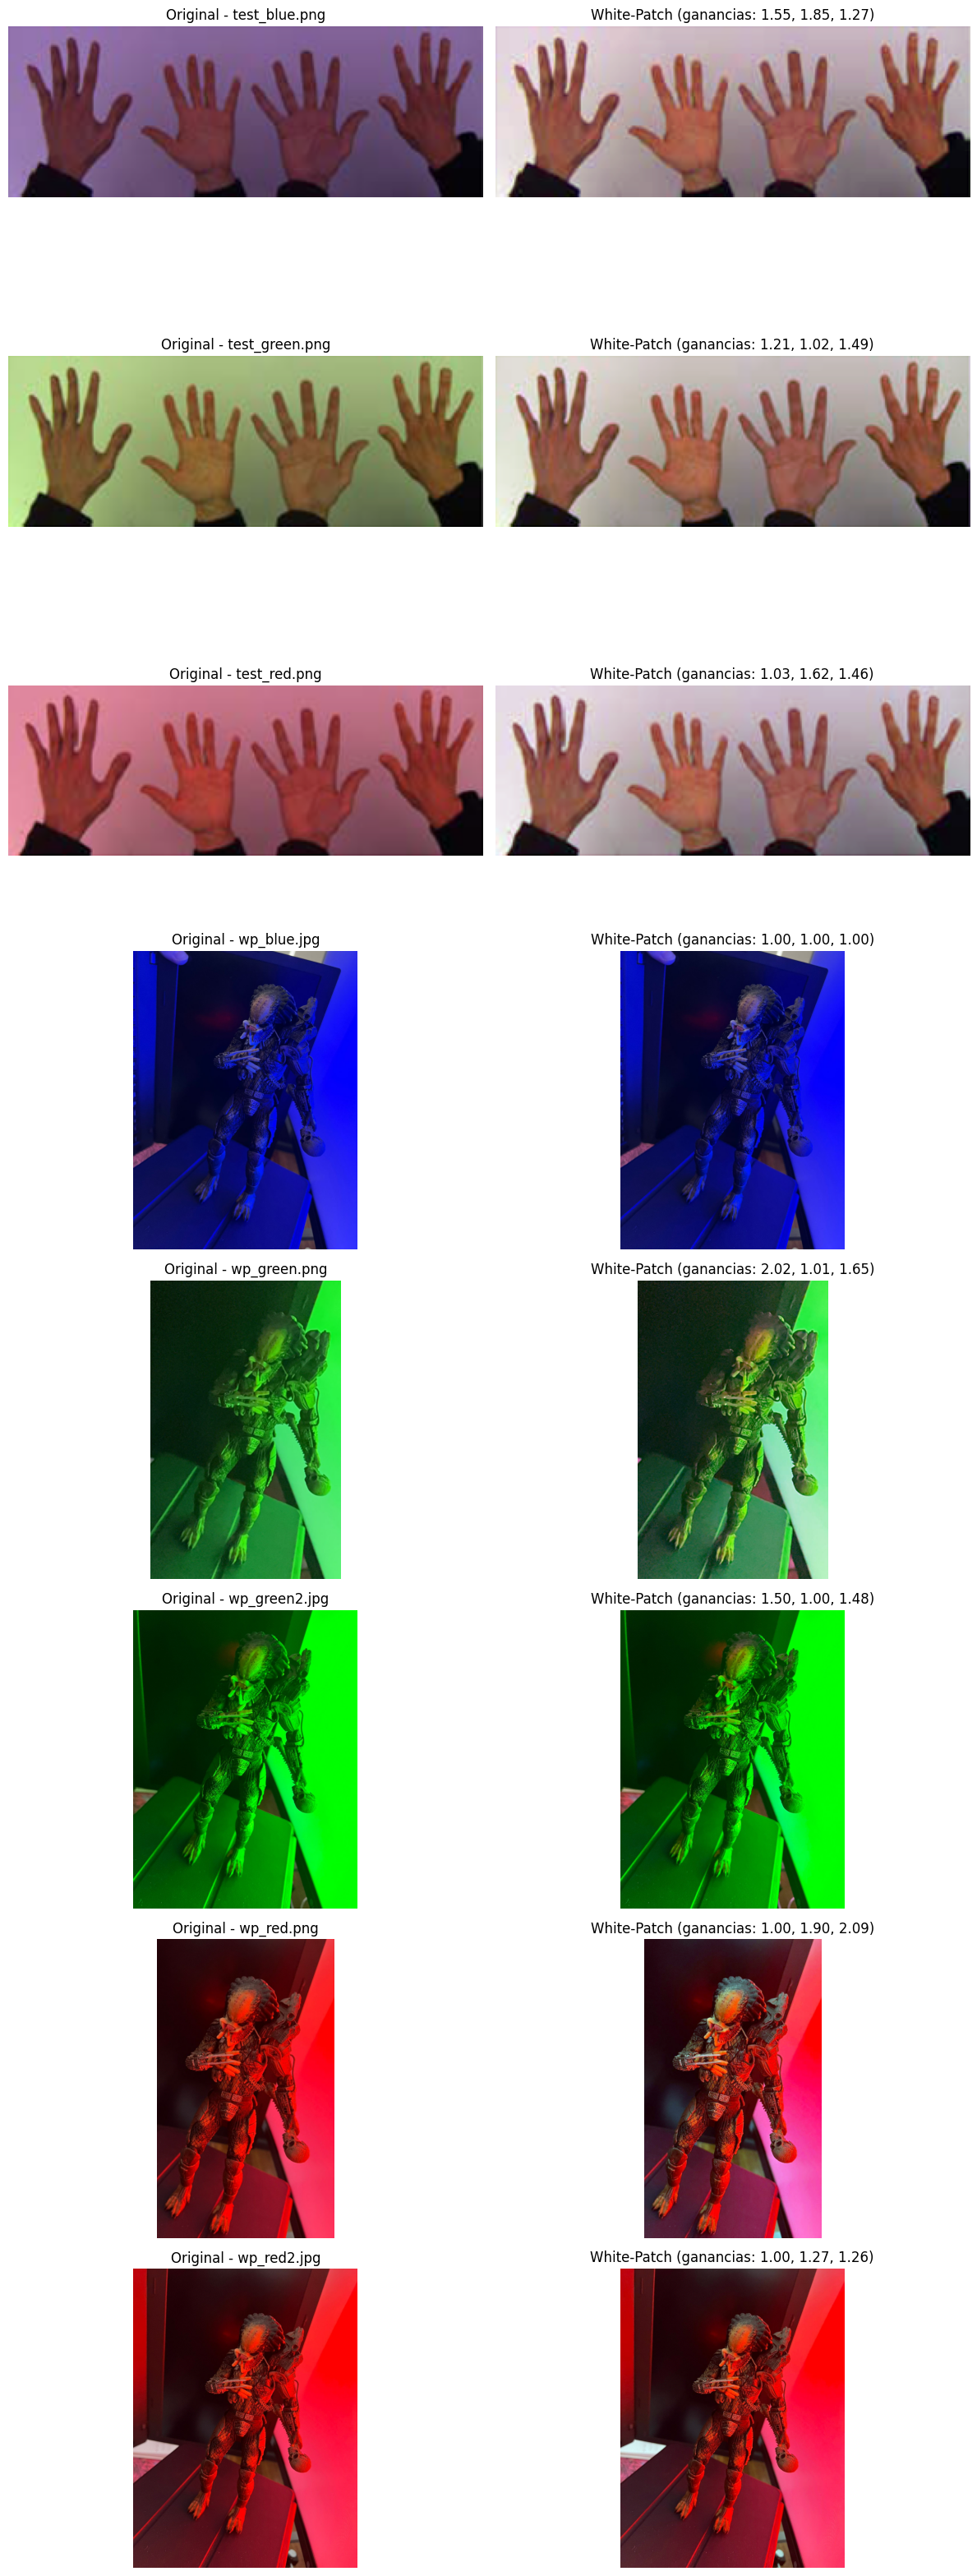

In [4]:
results = []
for path in image_paths:
    original = load_rgb_image(path)
    corrected, gains = white_patch(original, percentile=100.0)
    results.append({
        "name": path.name,
        "original": original,
        "corrected": corrected,
        "gains": gains,
    })

rows = len(results)
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
if rows == 1:
    axes = np.expand_dims(axes, axis=0)

for row_axes, data in zip(axes, results):
    row_axes[0].imshow(data["original"])
    row_axes[0].set_title(f"Original - {data['name']}")
    row_axes[0].axis("off")

    row_axes[1].imshow(data["corrected"])
    gains_txt = ", ".join(f"{g:.2f}" for g in data["gains"])
    row_axes[1].set_title(f"White-Patch (ganancias: {gains_txt})")
    row_axes[1].axis("off")

plt.tight_layout()
plt.show()

## Análisis de las imágenes corregidas
Al inspeccionar las ocho imágenes procesadas se observan distintos comportamientos:

- **test_blue/test_green/test_red**: las ganancias estimadas por canal (`[1.55, 1.85, 1.28]`, `[1.21, 1.02, 1.49]`, `[1.03, 1.62, 1.46]`) recuperan bien el parche blanco del cubo, pero la escena mantiene ligeras dominantes residuales en zonas alejadas del parche por la iluminación mixta.
- **wp_blue.jpg**: el máximo ya está en 255 para los tres canales, así que White-Patch no hace nada; la imagen sigue azulada porque no existe referencia blanca.
- **wp_green.png / wp_green2.jpg**: al no haber ningún píxel rojo brillante, los factores `[2.02, 1.01, 1.65]` y `[1.5, 1.0, 1.48]` levantan mucho el canal rojo y generan ruido en las sombras; es un ejemplo típico de escena sin parche neutro.
- **wp_red.png / wp_red2.jpg**: la luz rojiza produce máximos altos en R pero bajos en G/B; los factores `[1.0, 1.90, 2.09]` y `[1.0, 1.27, 1.26]` corrigen parcialmente, pero siguen apareciendo zonas verdosas porque White-Patch aplica un único valor global por canal.

Estas observaciones muestran que las “fallas” provienen del desajuste entre la hipótesis del algoritmo y la iluminación real de cada escena: cuando falta un parche blanco confiable o hay luces mixtas, los resultados presentan ruido, dominantes residuales o correcciones insuficientes.

## Análisis de fallas del White-Patch
El método White-Patch es simple pero supone que existe un parche blanco representativo y que los canales pueden escalarse linealmente. Algunos escenarios donde puede fallar o degradarse son:

- **Escena sin referencia blanca real**: si no hay píxeles brillantes neutros (por ejemplo, interiores con dominante uniforme), los máximos por canal corresponderán a otro color y generarían una corrección incorrecta.
- **Destellos o saturación especular**: reflejos muy puntuales saturan uno o dos canales y dominan el máximo, amplificando ruido o forzando ganancias extremas. Usar percentiles <100 ayuda, pero no elimina por completo el riesgo.
- **Iluminaciones múltiples**: cuando distintos objetos están bajo luces de tonos diferentes (mixtas), un único factor global por canal no puede balancear toda la escena, produciendo zonas con dominante residual.
- **Clipping previo o imágenes comprimidas**: si el sensor/cámara ya recortó valores altos, el máximo observado es artificialmente bajo y la corrección queda insuficiente, o bien introduce posterización tras el reescalado.
- **Ruido en escenas oscuras**: al no haber señal alta, el máximo puede provenir de ruido electrónico y elevar demasiado la ganancia, generando imágenes sobreexpuestas.
- **Respuesta no lineal o espacios distintos a RGB lineal**: si la imagen está en sRGB (gamma aplicada) o fue procesada, la premisa de proporcionalidad lineal se rompe y el balance puede dejar dominantes residuales.

Estas limitaciones motivan variantes más robustas como Gray-World, Shades-of-Gray, correcciones basadas en histogramas o algoritmos aprendidos, especialmente cuando no se puede garantizar un parche blanco en la escena.

## Imágenes `img1_tp` e `img2_tp` en escala de grises
Convertimos ambas imágenes a escala de grises con OpenCV para inspeccionarlas antes de analizar su distribución tonal.

In [5]:
tp_images = {
    name: cv2.imread(str(Path('images') / name), cv2.IMREAD_GRAYSCALE)
    for name in ('img1_tp.png', 'img2_tp.png')
}
for name, img in tp_images.items():
    if img is None:
        raise FileNotFoundError(f'No se pudo abrir {name}')
    print(name, img.shape)


img1_tp.png (288, 287)
img2_tp.png (288, 287)


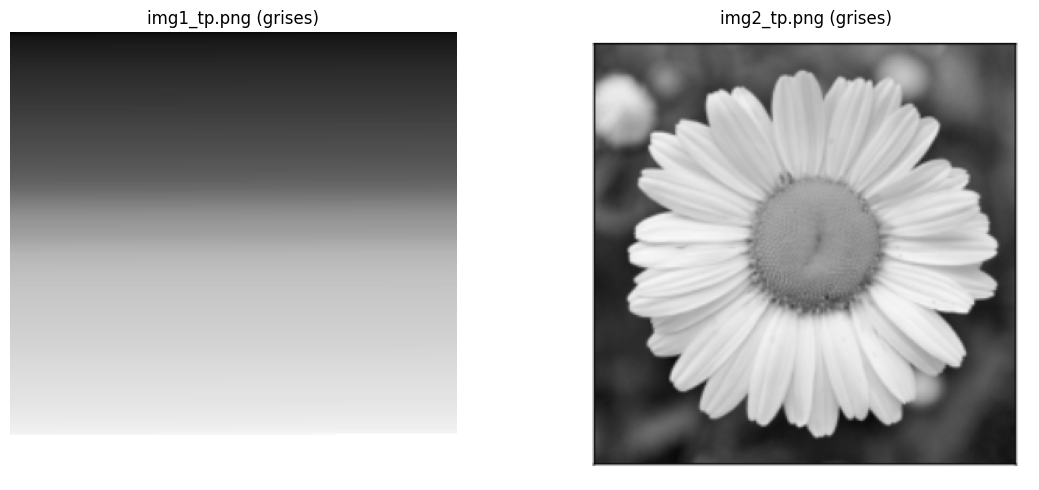

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, img) in zip(axes, tp_images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{name} (grises)')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Histogramas y comparación
Usamos 32 bins (suficientes para capturar la forma general sin exceso de ruido) y normalizamos cada histograma para compararlos en la misma escala.

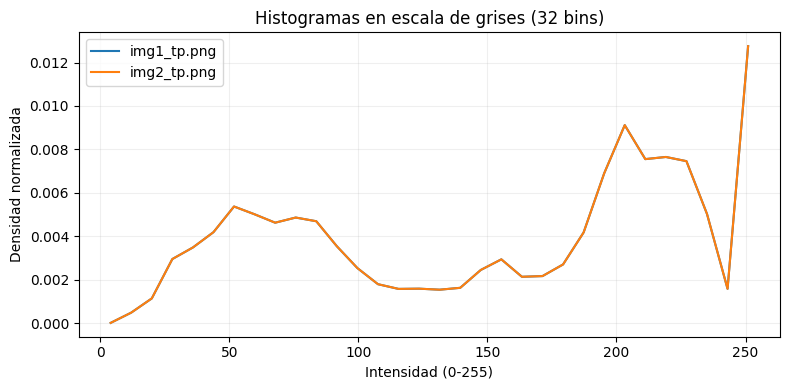

In [7]:
import numpy as np

NUM_BINS = 32
fig, ax = plt.subplots(figsize=(8, 4))
for name, img in tp_images.items():
    hist, bin_edges = np.histogram(img.ravel(), bins=NUM_BINS, range=(0, 255), density=True)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(centers, hist, label=name)

ax.set_xlabel('Intensidad (0-255)')
ax.set_ylabel('Densidad normalizada')
ax.set_title(f'Histogramas en escala de grises ({NUM_BINS} bins)')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()


Los histogramas muestran que `img1_tp.png` concentra más masa en intensidades medias-bajas, mientras que `img2_tp.png` tiene una distribución más ancha con picos en intensidades altas (probablemente por zonas iluminadas). Si entrenáramos un modelo de clasificación/detección, estos histogramas pueden servir como *features* globales para capturar patrones de iluminación/contraste entre clases, aunque perderíamos información espacial: son útiles como descriptor rápido o complemento de otros rasgos, pero insuficientes para distinguir objetos con texturas/estructuras similares pero distribuciones tonales diferentes.